In [1]:
from spikit import *

import numpy as np
import matplotlib.pyplot as plt

We first want to initialize our dressed system.

In [2]:
binary = Binary(1e3, 1)
dress = PowerLaw(binary, 7/3, 1e16)

# Some quantities related to the binary
risco = binary.Risco()
r2 = 100 *risco # [pc] Separation
rhill = binary.rhill(r2) # [pc]

u = binary.u2(r2) # [m] Velocity of the secondary
T = binary.T(r2) # [s] Period of the binary

And include the acting forces on it. Here, we only consider the feedback of accretion. The accretion force is only used to produce that.

In [3]:
acc = AccretionIso(dress) # A temporary force.
# We can also change the cross section of the accretion force
acc.csection = lambda u, m2 = None: pi *(3 *rhill)**2 *pc**2 # [m2] 

dfacc = AccretionDepletion(acc)

blueprint = StuckAccretionDepletedPowerLaw(acc) # A `blueprint` with analytical solutions.

In [4]:
# Let us very crudely integrate the distribution function of the spike for over N orbits.
Norbits = 25

t = 0
for i in range(100):
    dt = Norbits *T/100
    dfacc.dfeps_dt(r2, u)
    dress.f_eps += dfacc.dfeps_dt(r2, u) *dt
    t += dt

/Users/mybook/Documents/Coding Packages/spikekit/spikit/feedback.py:28: RuntimeWarning: invalid value encountered in sqrt
  vE = np.sqrt(2 *(self.binary.M1.Psi(r) -self.spike.eps) ) # m/s


Its distribution function will exhibit a well-like structure around the energies that correspond to the central potential at the separation.

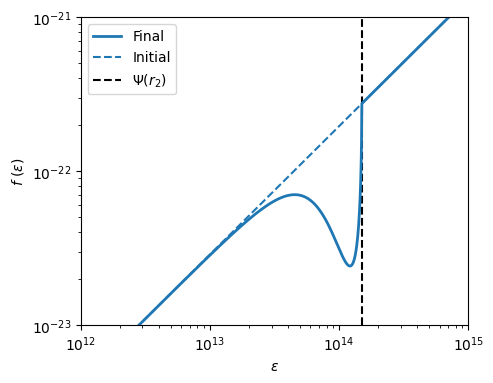

In [5]:
plt.figure(figsize = (5, 4))
plt.loglog(dress.eps, dress.f_eps, label = "Final", linewidth = 2)
plt.loglog(dress.eps, dress.feps_init(dress.eps), c = "C0", ls = "--", label = "Initial")

plt.axvline(binary.M1.Psi(r2), c = "k", ls = "--", label = "$\Psi(r_2)$", zorder = -1)

plt.xlabel("$\epsilon$")
plt.ylabel("$f\,\,(\epsilon)$")

plt.xlim(1e12, 1e15)
plt.ylim(1e-23, 1e-21)
plt.legend()

Consequently, the density of particles is depleted around the path of the companion.

Text(0, 0.5, '$\\rho\\,(\\mathrm{M}_\\odot\\,\\mathrm{pc}^{-3})$')

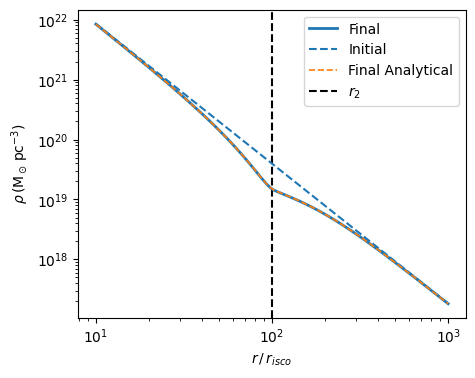

In [44]:
plt.figure(figsize = (5, 4))
r_grid = np.logspace(1, 3, 100) *risco # [pc]
rho_grid = np.array([dress.rho(r) for r in r_grid]) # [Msun/pc^3]

plt.loglog(r_grid/risco, rho_grid, label = "Final", linewidth = 2)
plt.loglog(r_grid/risco, dress.rho_init(r_grid), c = "C0", ls = "--", label = "Initial")

rho_ = np.vectorize(blueprint.rho)(r_grid, r2, t)
plt.loglog(r_grid/risco, rho_, label = "Final Analytical", c = "C1", ls = "--", linewidth = 1.2)
plt.axvline(r2/risco, c = "k", ls = "--", label = "$r_2$", zorder = -1)

plt.legend()

plt.xlabel("$r\,/\,r_{isco}$")
plt.ylabel("$\\rho\,(\mathrm{M}_\odot\,\mathrm{pc}^{-3})$")

Using the blueprint we can quickly explore various relations. Such as the time-evolution of the well's depth.

Text(0, 0.5, '$\\rho(r_2, t)/\\rho(r_2, 0)$')

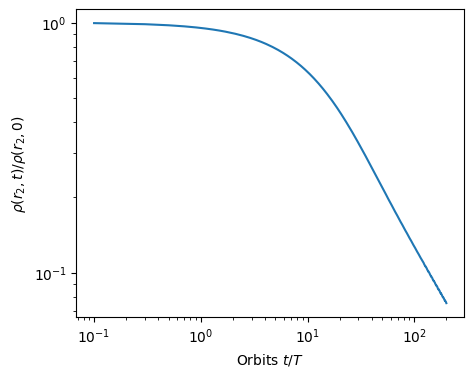

In [49]:
N = np.linspace(0.1, 200, 1000)

rho = np.vectorize(blueprint.rho)(r2, r2, N *T)
rho0 = blueprint.rho(r2, r2, 0)

plt.figure(figsize = (5, 4))
plt.loglog(N, rho/rho0, label = "$\gamma = 2$")

plt.xlabel("Orbits $t/T$")
plt.ylabel("$\\rho(r_2, t)/\\rho(r_2, 0)$")